# Query AODN parquet dataset:

Creation of a python class ```GetAodn``` to:
- retrieve as a dictionnary all metadata from all parquet dataset available on a S3 bucket 
- search for dataset containing specific variable/attributes ....
- retrieve data from a dataset with time, bounding box and scalar filter as a panda dataframe

In [ ]:
!pip install fuzzywuzzy
!pip install s3fs -U
!pip install pyarrow==16.0.0 -U
!pip install zarr xarray[complete]
!pip install pandas==2.2.2 -U
!pip install hvplot

In [1]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/IMOS-hackathon/main/2024/Tutorials/cloud_optimised_notebooks/parquet_queries.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)


In [2]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc
import boto3
from fuzzywuzzy import fuzz
from botocore import UNSIGNED
from botocore.client import Config
from functools import lru_cache

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# GetAodn Class definition

In [3]:
class GetAodn:
    def __init__(self):
        self.bucket_name = "imos-data-lab-optimised"
        self.prefix = 'parquet/loz_test'
        
    def get_dataset(self, dataset_name):
        return Dataset(self.bucket_name, self.prefix, dataset_name)
        
    def get_metadata(self):
        return Metadata(self.bucket_name, self.prefix)

class Dataset:
    def __init__(self, bucket_name, prefix, dataset_name):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.dataset_name = dataset_name
        self.dname = f"s3://{self.bucket_name}/{self.prefix}/{self.dataset_name}.parquet/"
        self.parquet_ds = pq.ParquetDataset(self.dname, partitioning='hive')
        
    def partition_keys_list(self):
        dataset = pq.ParquetDataset(self.dname, format="parquet", partitioning="hive")
        partition_keys = dataset.partitioning.schema
        return partition_keys

    def get_spatial_extent(self):
        return get_spatial_extent(self.parquet_ds)

    def plot_spatial_extent(self):
        return plot_spatial_extent(self.parquet_ds)

    def get_temporal_extent(self):
        return get_temporal_extent(self.parquet_ds)

    def get_data(self, date_start=None, date_end=None, lat_min=None, lat_max=None, lon_min=None, lon_max=None, scalar_filter=None):
        # TODO fix the whole logic as not everything is considered
        if date_start == None or date_end == None:
            filter_time = None
        else:
            filter_time = create_time_filter(self.parquet_ds, date_start=date_start, date_end=date_end)
                        
        if lat_min == None or lat_max == None or lon_min == None or lon_max == None:
            filter_geo = None
        else:
            filter_geo = create_bbox_filter(self.parquet_ds, lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)

        if scalar_filter !=None:
            expr = None
            for item in scalar_filter:
                expr_1 = pc.field(item) == pa.scalar(scalar_filter[item])
                if type(expr) != pc.Expression:
                    expr = expr_1
                else:
                    expr = expr_1 & expr
        
        if type(filter_time) != pc.Expression:
            data_filter = filter_geo
        elif type(filter_geo) != pc.Expression:
            data_filter = filter_time
        else:
            data_filter = filter_geo & filter_time

        if scalar_filter != None:
            data_filter = data_filter & expr
        df = pd.read_parquet(self.dname, engine='pyarrow', filters=data_filter)
        return df

    def get_metadata(self):
         return get_schema_metadata(self.dname)

class Metadata:
        def __init__(self, bucket_name, prefix):
            #super().__init__()
            # initialise the class by calling the needed methods
            self.bucket_name = bucket_name
            self.prefix = prefix
            self.catalog = self.metadata_catalog()

        def metadata_catalog_uncached(self):
            #print('Running metadata_catalog_uncached...')  # Debug output

            folders_with_parquet = self.list_folders_with_parquet()
            catalog = {}
    
            for dataset in folders_with_parquet:
                dname = f"s3://{self.bucket_name}/{dataset}"
                metadata = get_schema_metadata(dname)  # schema metadata
    
                path_parts = dataset.strip('/').split('/')
                last_folder_with_extension = path_parts[-1]
                dataset_name = os.path.splitext(last_folder_with_extension)[0]
    
                catalog[dataset_name] = metadata
    
            return catalog

        @lru_cache(maxsize=None)
        def metadata_catalog(self):
            #print('Running metadata_catalog...')  # Debug output
            if 'catalog' in self.__dict__:
                return self.catalog
            else:
                return self.metadata_catalog_uncached()
    
        def list_folders_with_parquet(self):
            s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
            prefix = self.prefix
    
            if not prefix.endswith('/'):
                prefix += '/'
    
            response = s3.list_objects_v2(
                Bucket=self.bucket_name,
                Prefix=prefix,
                Delimiter='/'
            )
    
            folders = []
            for prefix in response.get('CommonPrefixes', []):
                folder_path = prefix['Prefix']
                if folder_path.endswith('.parquet/'):
                    folder_name = folder_path[len(prefix) - 1:]
                    folders.append(folder_name)
    
            return folders
    
        def find_datasets_with_attribute(self, target_value, target_key='standard_name', data_dict=None, threshold=80):

            matching_datasets = []
            # https://stackoverflow.com/questions/56535948/python-why-cant-you-use-a-self-variable-as-an-optional-argument-in-a-method
            if data_dict == None:
                data_dict = self.metadata_catalog()
        
            if not isinstance(data_dict, dict):
                return matching_datasets # handle bad cases
                
            for dataset_name, attributes in data_dict.items():
                if not isinstance(attributes, dict):
                    continue  
        
                for key, value in attributes.items():
                    if isinstance(value, dict) and target_key in value:
                        # Check for any attribute available in a dict(catalog) match using fuzzy matching
                        current_standard_name = value.get(target_key, '')
                        similarity_score = fuzz.partial_ratio(target_value.lower(), current_standard_name.lower())
                        if similarity_score >= threshold:
                            matching_datasets.append(dataset_name)  # Add dataset name to list
        
                    # Recursively search
                    matching_datasets.extend(self.find_datasets_with_attribute(value, target_value, threshold))
        
            return list(set(matching_datasets))

## Examples to use class

In [4]:
aodn_instance = GetAodn()

### Retrieving all parquet dataset information

In [5]:
# Creating a subinstance to use caching capability (maybe there's a cleaner way)
aodn_meta = aodn_instance.get_metadata()  
aodn_meta.metadata_catalog()

{'aatams_acoustic_tagging': {'detection_timestamp': {'type': 'timestamp[ns]',
   'standard_name': 'time',
   'long_name': '',
   'units': 's',
   'comments': ''},
  'transmitter_id': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'installation_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'station_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'receiver_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'latitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'longitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_value': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_unit': 

### Find all dataset containing specific information (such as temperature)

In [6]:
aodn_meta.find_datasets_with_attribute('temp', target_key='standard_name' )

['argo_core',
 'anmn_hourly_timeseries',
 'anmn_temperature_logger_ts_fv01',
 'soop_xbt_nrt']

### Get SOOP XBT data

In [7]:
aodn_instance.get_dataset('soop_xbt_nrt').get_temporal_extent()

(datetime.datetime(2020, 9, 1, 10, 0), datetime.datetime(2024, 4, 1, 11, 0))

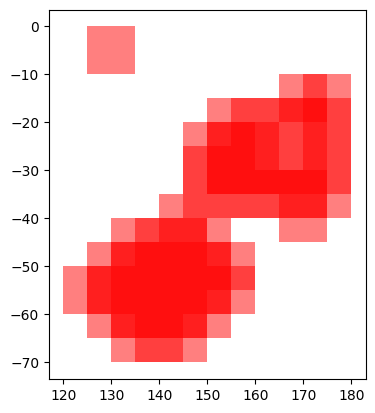

In [8]:
aodn_instance.get_dataset('soop_xbt_nrt').plot_spatial_extent()

In [9]:
df = aodn_instance.get_dataset('soop_xbt_nrt').get_data(date_start='2023-01-31 10:14:00', 
                                                   date_end='2024-02-01 07:50:00',
                                                   lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)

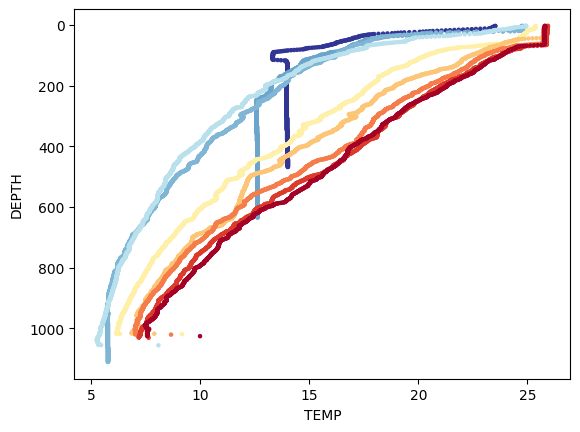

In [10]:
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME',                                                                      
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None").invert_yaxis()

In [11]:
df

,TIME,LATITUDE,LONGITUDE,DEPTH,DEPTH_quality_control,TEMP,TEMP_quality_control,imo_number,ship_name,Callsign,filename,XBT_line,timestamp,polygon
0,2024-01-28 05:41:00,-32.97142,151.99845,0.00,9.0,23.59,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
1,2024-01-28 05:41:00,-32.97142,151.99845,0.67,9.0,23.58,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
2,2024-01-28 05:41:00,-32.97142,151.99845,1.34,9.0,23.57,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
3,2024-01-28 05:41:00,-32.97142,151.99845,2.01,9.0,23.56,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
4,2024-01-28 05:41:00,-32.97142,151.99845,2.68,9.0,23.54,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,2024-01-28 21:01:00,-33.20854,154.99796,1107.43,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14189,2024-01-28 21:01:00,-33.20854,154.99796,1108.17,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14190,2024-01-28 21:01:00,-33.20854,154.99796,1108.91,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14191,2024-01-28 21:01:00,-33.20854,154.99796,1109.65,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...


### Get anmn hourly timeseries

In [12]:
aodn_instance = GetAodn()

In [13]:
aodn_instance.get_dataset('anmn_hourly_timeseries').get_temporal_extent()

(datetime.datetime(2007, 7, 1, 10, 0), datetime.datetime(2024, 1, 1, 11, 0))

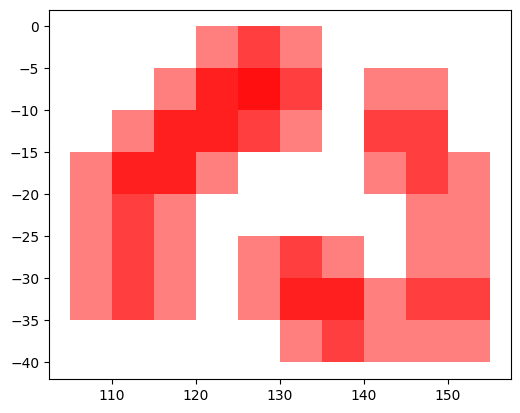

In [14]:
aodn_instance.get_dataset('anmn_hourly_timeseries').plot_spatial_extent()

### Filter hourly timeseries for site BMP070

In [15]:
df = aodn_instance.get_dataset('anmn_hourly_timeseries').get_data(date_start='2010-01-01 10:14:00', date_end='2024-02-01 07:50:00',
                                                                  scalar_filter={"site_code": "BMP070"})                                               

In [16]:
df

,instrument_index,instrument_id,source_file,TIME,LONGITUDE,LATITUDE,NOMINAL_DEPTH,DEPTH,DEPTH_count,DEPTH_min,...,CHLU_min,CHLU_std,CPHL,CPHL_count,CPHL_max,CPHL_min,CPHL_std,site_code,timestamp,polygon
0,0,BMP070-1411; Aquatec Aqualogger 520T; 023-590,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-18 22:00:00,150.188517,-36.18970,48.0,53.337482,7.0,53.288197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
1,0,BMP070-1411; Aquatec Aqualogger 520T; 023-590,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-18 23:00:00,150.188517,-36.18970,48.0,53.139858,12.0,53.032616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
2,0,BMP070-1411; Aquatec Aqualogger 520T; 023-590,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-19 00:00:00,150.188517,-36.18970,48.0,52.907757,12.0,52.809708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
3,0,BMP070-1411; Aquatec Aqualogger 520T; 023-590,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-19 01:00:00,150.188517,-36.18970,48.0,52.737152,12.0,52.678982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
4,0,BMP070-1411; Aquatec Aqualogger 520T; 023-590,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-19 02:00:00,150.188517,-36.18970,48.0,52.650455,12.0,52.619534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689354,241,BMP070-2308; Aquatec Aqualogger 520T; 023-1240,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2023-12-03 15:00:00,150.189333,-36.19105,52.0,52.269501,12.0,52.226700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1696118400,0103000000010000000500000000000000002062400000...
689355,241,BMP070-2308; Aquatec Aqualogger 520T; 023-1240,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2023-12-03 16:00:00,150.189333,-36.19105,52.0,52.344311,12.0,52.325478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1696118400,0103000000010000000500000000000000002062400000...
689356,241,BMP070-2308; Aquatec Aqualogger 520T; 023-1240,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2023-12-03 17:00:00,150.189333,-36.19105,52.0,52.362309,12.0,52.317142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1696118400,0103000000010000000500000000000000002062400000...
689357,241,BMP070-2308; Aquatec Aqualogger 520T; 023-1240,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2023-12-03 18:00:00,150.189333,-36.19105,52.0,52.365746,12.0,52.303082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1696118400,0103000000010000000500000000000000002062400000...


### Create a "climatology" for BPM070 at NOMINAL_DEPTH=52

Create a new variable **TEMP_CLIMATOLOGY** which is the daily mean over the available years.

In [17]:
import hvplot.pandas  # Import hvplot extension for pandas DataFrame
import holoviews as hv

In [18]:
# create a new variable DAY_MONTH in order to filter the data later on..
df['DAY_MONTH'] = df['TIME'].dt.strftime('%m-%d')

# Group by day and month, calculate daily mean temperature
daily_mean = df.groupby('DAY_MONTH')['TEMP'].mean().reset_index()
daily_mean.columns = ['DAY_MONTH', 'TEMP_CLIMATOLOGY']

# Merge back to original DataFrame on DAY_MONTH
df = pd.merge(df, daily_mean, on='DAY_MONTH', how='left')

# Drop the intermediate column 'DAY_MONTH'
df.drop('DAY_MONTH', axis=1, inplace=True)

#### Plot the TEMP variable and TEMP_CLIMATOLOGY together

#### Interactive plot with hvplot

In [ ]:
df = df[df["NOMINAL_DEPTH"] == 52].sort_values('TIME')

In [ ]:
# Create hvplot line plots for TEMP and TEMP_CLIMATOLOGY
temp_plot = df.hvplot.line(x='TIME', y='TEMP', label='TEMP', color='blue', ylabel='Temperature', xlabel='Time')
climatology_plot = df.hvplot.line(x='TIME', y='TEMP_CLIMATOLOGY', label='TEMP_CLIMATOLOGY', color='lightcoral')

overlay = (temp_plot * climatology_plot)

# Create a shaded area between the two line plots
filled_area = hv.Area((df['TIME'], df['TEMP'], df['TEMP_CLIMATOLOGY']), vdims=['TEMP', 'TEMP_CLIMATOLOGY']).opts(alpha=0.3, color='gray')

# Combine the line plot overlay with the filled area
combined_plot = (overlay * filled_area).opts(width=800, height=400, responsive=True)

# Show the combined plot
combined_plot

:Overlay
   .Curve.TEMP             :Curve   [TIME]   (TEMP)
   .Curve.TEMP_CLIMATOLOGY :Curve   [TIME]   (TEMP_CLIMATOLOGY)
   .Area.I                 :Area   [x]   (TEMP,TEMP_CLIMATOLOGY)

#### Non-Interactive plot

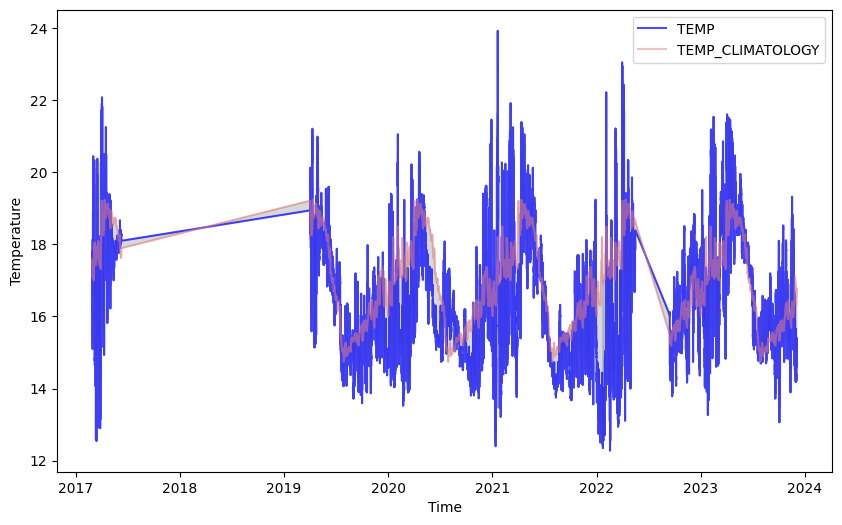

In [22]:
import matplotlib.pyplot as plt

# Plot TEMP and TEMP_CLIMATOLOGY
plt.figure(figsize=(10, 6))
plt.plot(df['TIME'], df['TEMP'], label='TEMP', color='blue', alpha=0.7)
plt.plot(df['TIME'], df['TEMP_CLIMATOLOGY'], label='TEMP_CLIMATOLOGY', color='lightcoral', alpha=0.5)

# Fill between TEMP and TEMP_CLIMATOLOGY
plt.fill_between(df['TIME'], df['TEMP'], df['TEMP_CLIMATOLOGY'], color='gray', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

# Show the plot
plt.show()